In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from string import ascii_lowercase
from sklearn.preprocessing import scale
import matplotlib
import svgutils.transform as st
from matplotlib import gridspec, pyplot as plt
from syserol.tensor import perform_CMTF
from syserol.dataImport import getAxes, load_file
from syserol.figures.common import getSetup
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from scipy.stats import zscore

In [2]:
def getClassY(df):
    """ Extract Ys for classification. """
    Y1 = (df["class.cp"] == "controller").astype(int)  # controllers are 1s, progressors are 0s
    Y2 = (df["class.nv"] == "viremic").astype(int)  # viremic = 1, nonviremic = 0
    return Y1, Y2

In [3]:
def class_predictions(X):
    """ Predict Subject Class with Decomposed Tensor Data """
    # Load Data
    cp, nv = getClassY(load_file("meta-subjects"))

    # Controller/Progressor classification
    _, cp_accuracy, coef_cp = ClassifyHelper(X, cp)

    # Viremic/Nonviremic classification
    _, nv_accuracy, coef_nv = ClassifyHelper(X, nv)

    return cp_accuracy, nv_accuracy, coef_cp, coef_nv
def ClassifyHelper(X, Y):
    """ Function with common Logistic regression methods. """
    regr = LogisticRegressionCV(n_jobs=-1, cv=40, max_iter=1000).fit(X, Y)
    clf = LogisticRegression(C=regr.C_[0], max_iter=1000).fit(X, Y)
    coef = clf.coef_
    Y_pred = cross_val_predict(clf, X, Y, cv=40, n_jobs=-1)
    return Y_pred, accuracy_score(Y, Y_pred), coef

In [3]:
tFac, _, _ = perform_CMTF()

Missingness fraction: 0.4268292682926829


In [5]:
cp_accuracy, nv_accuracy, cp_coef, nv_coef = class_predictions(tFac[1][0])
print(cp_accuracy, nv_accuracy)

0.7403314917127072 0.7403314917127072


In [4]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
def find_SVC_proba(X, Y, method="decision_function"):
    proba = cross_val_predict(SVC(kernel='rbf'), X, Y, cv=40, method=method)
    return proba

In [31]:
pd.set_option("display.max_rows", 10)

In [5]:
def class_predictions(X):
    """ Predict Subject Class with Decomposed Tensor Data """
    # Load Data
    cp, nv = getClassY(load_file("meta-subjects"))

    # Controller/Progressor classification
    _, cp_accuracy, coef_cp = ClassifyHelper(X, cp)

    # Viremic/Nonviremic classification
    _, nv_accuracy, coef_nv = ClassifyHelper(X, nv)

    return cp_accuracy, nv_accuracy, coef_cp, coef_nv
def ClassifyHelper(X, Y):
    """ Function with common Logistic regression methods. """
    for comp in range(2, 11):
    print(comp)
    values_comps = []
    for i in range(0, comp - 1):
        for j in range(i + 1, comp):
            double = np.vstack((X[:, i], X[:, j])).T
            decisions = find_SVC_proba(double, Y, method="decision_function")     
            auc = roc_auc_score(Y, decisions)
            values_comps.append([i, j, auc])
    df_comp = pd.DataFrame(values_comps)
    df_comp.columns = ["First", "Second", "AUC"]
    df_comp = df_comp.sort_values(by='AUC', ascending=False)
    display(df_comp.head())
    best = np.vstack((X[:, df_comp.iloc[0, 0]], X[:, df_comp.iloc[0, 1]])).T
    decisions = find_SVC_proba(best, Y, method="decision_function")
    fpr, tpr, thresholds = roc_curve(outcomes, decisions)
    thresh = pd.DataFrame({"Ratio": tpr - fpr, "Threshold": thresholds})
    thresh = thresh.sort_values(by='Ratio', ascending=False)
    #thresh = thresh.replace([np.inf, -np.inf], np.nan).dropna()
    display(thresh.head())
    Y_pred = (decisions >= thresh.iloc[0, 1]).astype(bool)
    return Y_pred, accuracy_score(Y, Y_pred), coef

IndentationError: expected an indented block (<ipython-input-5-10077fc5f1e1>, line 16)

In [38]:
def class_predictions(X):
    """ Predict Subject Class with Decomposed Tensor Data """
    # Load Data
    cp, nv = getClassY(load_file("meta-subjects"))

    # Controller/Progressor classification
    _, cp_accuracy, best_comps_cp = ClassifyHelper(X, cp)

    # Viremic/Nonviremic classification
    _, nv_accuracy, best_comps_nv = ClassifyHelper(X, nv)

    return cp_accuracy, nv_accuracy, best_comps_cp, best_comps_nv
def ClassifyHelper(X, Y):
    """ Function with common Logistic regression methods. """
    comp = 10
    values_comps = []
    for i in range(0, comp - 1):
        for j in range(i + 1, comp):
            double = np.vstack((X[:, i], X[:, j])).T
            decisions = find_SVC_proba(double, Y, method="predict")        
            auc = roc_auc_score(Y, decisions)
            values_comps.append([i, j, auc])
    df_comp = pd.DataFrame(values_comps)
    df_comp.columns = ["First", "Second", "AUC"]
    df_comp = df_comp.sort_values(by='AUC', ascending=False)
    display(df_comp)
    best = np.vstack((X[:, df_comp.iloc[0, 0]], X[:, df_comp.iloc[0, 1]])).T
    Y_pred = find_SVC_proba(best, Y, method="predict")
    from sklearn.model_selection import LeaveOneOut
    loo = LeaveOneOut()
    bests = []
    worsts = []
    choices = []
    for train, test in loo.split(X):
        values_comps = []
        for i in range(0, comp - 1):
            for j in range(i + 1, comp):
                    double = np.vstack((X[train, i], X[train, j])).T
                    decisions = find_SVC_proba(double, Y[train], method="predict")        
                    auc = roc_auc_score(Y[train], decisions)
                    values_comps.append([i, j, auc])
        df_comp = pd.DataFrame(values_comps)
        df_comp.columns = ["First", "Second", "AUC"]
        df_comp = df_comp.sort_values(by=["AUC"], ascending=False)
        best1 = df_comp.iloc[0, 0]
        best2 = df_comp.iloc[0, 1]
        clf = SVC().fit(np.vstack((X[train, best1], X[train, best2])).T, Y[train])
        choices.append(clf.predict(np.vstack((X[test, best1], X[test, best2])).T))
        bests.append(df_comp.iloc[0, :])
        worsts.append(df_comp.iloc[-1, :])
    best_auc = roc_auc_score(Y, choices)
    print(best_auc, bests[:30], worsts[:30])
    return Y_pred, accuracy_score(Y, Y_pred), (df_comp.iloc[0, 0], df_comp.iloc[0, 1])

In [39]:
cp_accuracy, nv_accuracy, best_comps_cp, best_comps_nv = class_predictions(tFac[1][0])
print(cp_accuracy, nv_accuracy)

First  Second       AUC
4       0       5  0.784681
36      5       7  0.782598
38      5       9  0.772549
30      4       5  0.762255
19      2       5  0.752941
..    ...     ...       ...
13      1       6  0.464216
15      1       8  0.460172
26      3       6  0.443750
28      3       8  0.441789
16      1       9  0.391299

[45 rows x 3 columns]

0.7558210784313726 [First     5.000000
Second    7.000000
AUC       0.740557
Name: 36, dtype: float64, First     5.000000
Second    7.000000
AUC       0.740557
Name: 36, dtype: float64, First     5.000000
Second    7.000000
AUC       0.740557
Name: 36, dtype: float64, First     5.000000
Second    7.000000
AUC       0.740557
Name: 36, dtype: float64, First     5.000000
Second    7.000000
AUC       0.740557
Name: 36, dtype: float64, First     0.000000
Second    5.000000
AUC       0.755108
Name: 4, dtype: float64, First     0.000000
Second    5.000000
AUC       0.743344
Name: 4, dtype: float64, First     0.000000
Second    5.000000
AUC       0.743344
Name: 4, dtype: float64, First     0.000000
Second    5.000000
AUC       0.749226
Name: 4, dtype: float64, First     0.000000
Second    5.000000
AUC       0.743344
Name: 4, dtype: float64, First     0.000000
Second    5.000000
AUC       0.755108
Name: 4, dtype: float64, First     0.000000
Second    5.000000
AUC       0.760372
Name: 4, dtype: 

First  Second       AUC
18      2       4  0.796287
0       0       1  0.793356
31      4       6  0.786273
23      2       9  0.779922
11      1       4  0.777968
..    ...     ...       ...
40      6       8  0.695530
26      3       6  0.693942
35      5       6  0.692110
28      3       8  0.679531
10      1       3  0.660112

[45 rows x 3 columns]

0.7564728871519296 [First     0.000000
Second    1.000000
AUC       0.754941
Name: 0, dtype: float64, First     0.000000
Second    1.000000
AUC       0.754941
Name: 0, dtype: float64, First     0.000000
Second    1.000000
AUC       0.754941
Name: 0, dtype: float64, First     0.000000
Second    1.000000
AUC       0.754941
Name: 0, dtype: float64, First     0.000000
Second    1.000000
AUC       0.754941
Name: 0, dtype: float64, First     0.000000
Second    1.000000
AUC       0.754941
Name: 0, dtype: float64, First     0.000000
Second    1.000000
AUC       0.754941
Name: 0, dtype: float64, First     0.000000
Second    1.000000
AUC       0.754941
Name: 0, dtype: float64, First     0.000000
Second    1.000000
AUC       0.749259
Name: 0, dtype: float64, First     0.000000
Second    1.000000
AUC       0.754941
Name: 0, dtype: float64, First     0.000000
Second    1.000000
AUC       0.754941
Name: 0, dtype: float64, First     0.000000
Second    1.000000
AUC       0.754941
Name: 0, dtype: float

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
bests = []
choices = []
for train, test in loo.split(patient_matrix):
    values_comps = []
    for i in range(0, components - 1):
        for j in range(i + 1, components):
                double = np.vstack((patient_matrix[train, i], patient_matrix[train, j])).T
                decisions = find_SVC_proba(double, outcomes[train])        
                auc = roc_auc_score(outcomes[train], decisions)
                values_comps.append([i, j, auc])
    df_comp = pd.DataFrame(values_comps)
    df_comp.columns = ["First", "Second", "AUC"]
    df_comp = df_comp.sort_values(by=["AUC"], ascending=False)
    best1 = df_comp.iloc[0, 0]
    best2 = df_comp.iloc[0, 1]
    clf = SVC().fit(np.vstack((patient_matrix[train, best1], patient_matrix[train, best2])).T, outcomes[train])
    choices.append(clf.decision_function(np.vstack((patient_matrix[test, best1], patient_matrix[test, best2])).T))
    bests.append(df_comp.iloc[:3, :])
best_auc = roc_auc_score(outcomes, choices)

In [2]:
tensorFac, matrixFac, _ = perform_CMTF()

# Gather tensor data matrices
subjects = np.squeeze(tensorFac.factors[0])
receptors = np.squeeze(tensorFac.factors[1])
antigens = np.squeeze(tensorFac.factors[2])
glyc = np.squeeze(matrixFac.factors[1])

# Gather grouping info
glycaninf = load_file("meta-glycans")
glycaninf = glycaninf.replace(
    to_replace=["false", "b", "f", "g1", "g2", "g0", "s"],
    value=["", "B", "F", "G1", "G2", "G0", "S"],
)
for i in np.arange(0, len(glycaninf)):
    if "S1" in glycaninf.iloc[i, 0]:
        glycaninf.iloc[i, 2] = "S1"
    if "S2" in glycaninf.iloc[i, 0]:
        glycaninf.iloc[i, 2] = "S2"
glycaninf["FB"] = glycaninf["f"] + glycaninf["b"]
glycaninf["GS"] = glycaninf["g"] + glycaninf["s"]
glycaninf["FB"] = glycaninf["FB"].replace(to_replace=[np.nan, ""], value=["Total", "No F or B"])
glycaninf.loc[19:24, "GS"] = glycaninf.loc[19:24, "glycan"]
_, detections, antigen = getAxes()
subjinfo = load_file("meta-subjects")

Missingness fraction: 0.4268292682926829


Text(320.41341054860965, 0.5, '')

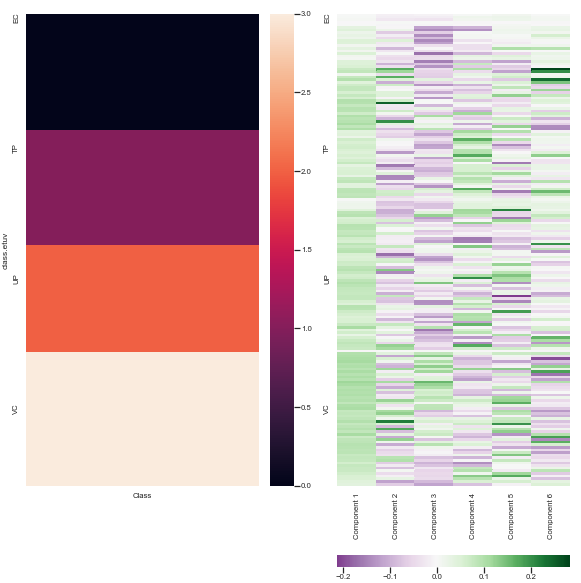

In [7]:
import matplotlib.pyplot as plt
ax, f = getSetup((8, 8), (1, 2))

cbar_kws = {"orientation":"horizontal"}
subs = pd.DataFrame(subjects, columns = [f"Component {i}" for i in np.arange(1, subjects.shape[1] + 1)], index=subjinfo["class.etuv"])
b1 = sns.heatmap(test, ax=ax[0], yticklabels=50)
a = sns.heatmap(subs, cmap="PRGn", center=0, xticklabels=True, yticklabels=50, cbar_kws=cbar_kws, ax=ax[1])
a.set_ylabel("")


Class
class.etuv       
EC              0
EC              0
EC              0
EC              0
EC              0
...           ...
VC              3
VC              3
VC              3
VC              3
VC              3

[181 rows x 1 columns]

[Text(0.5, 0, 'Class')]

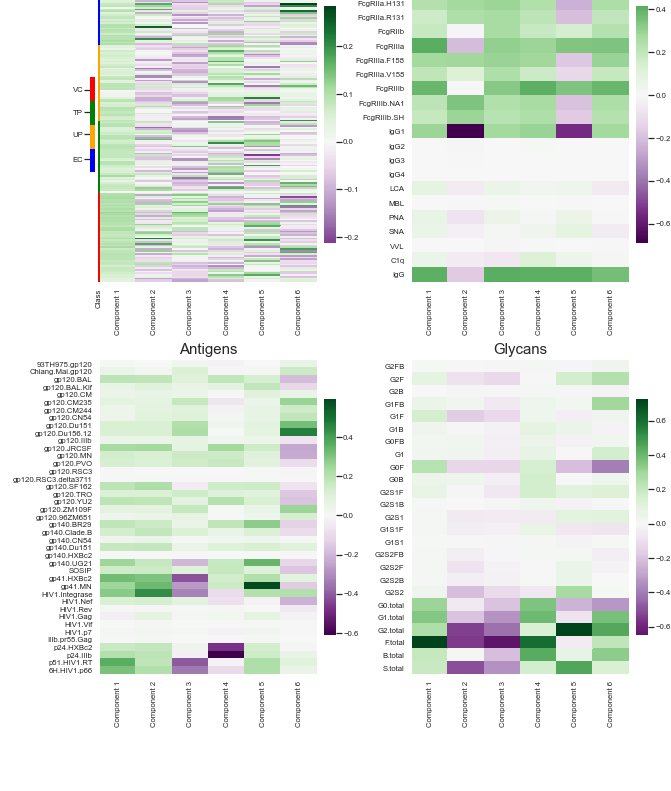

In [32]:
plt.figure(figsize=(10, 13))
gs = gridspec.GridSpec(2, 4,
                       width_ratios=[1, 25, 8, 25],
                       height_ratios=[1, 1],
                       wspace=0, hspace=.25
                       )
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax4 = plt.subplot(gs[3])
ax6 = plt.subplot(gs[5])
ax8 = plt.subplot(gs[7])


ax2.set_title("Subjects", fontsize=15)
ax4.set_title("Receptors", fontsize=15)
ax6.set_title("Antigens", fontsize=15)
ax8.set_title("Glycans", fontsize=15)


colors = ["blue", "orange", "green", "red"]
cmap = sns.color_palette(colors)
#cbar_kws = {"location":"top"}
subs = pd.DataFrame(subjects, columns = [f"Component {i}" for i in np.arange(1, subjects.shape[1] + 1)], index=subjinfo["class.etuv"])
sns.heatmap(subs, cmap="PRGn", center=0, xticklabels=True, yticklabels=False, cbar_kws=dict(fraction=.05, pad=.03), ax=ax2)

rec = pd.DataFrame(receptors, columns = [f"Component {i}" for i in np.arange(1, subjects.shape[1] + 1)], index=detections)
sns.heatmap(rec, cmap="PRGn", center=0, yticklabels=True, cbar_kws=dict(fraction=.05, pad=.03), ax=ax4)

ant = pd.DataFrame(antigens, columns=[f"Component {i}" for i in np.arange(1, subjects.shape[1] + 1)], index=antigen)
sns.heatmap(ant, cmap="PRGn", center=0, yticklabels=True, cbar_kws=dict(fraction=.05, pad=.03), ax=ax6)

glycans = pd.DataFrame(glyc, columns=[f"Component {i}" for i in np.arange(1, subjects.shape[1] + 1)], index=glycaninf["glycan"])
sns.heatmap(glycans, cmap="PRGn", center=0, yticklabels=True, cbar_kws=dict(fraction=.05, pad=.03), ax=ax8)

sns.heatmap(test, ax=ax1, cbar_kws=dict(use_gridspec=False, location="left", fraction=.5, pad=.3), yticklabels=False, xticklabels=True, cmap=cmap)
colorbar = ax1.collections[0].colorbar
colorbar.set_ticks([0.4, 1.2, 1.9, 2.6])
colorbar.set_ticklabels(['EC', 'UP', 'TP', "VC"])
ax1.set_ylabel("")
ax2.set_ylabel("")
ax8.set_ylabel("")
ax1.set_xticklabels(test.columns, rotation=90)

In [5]:
test = pd.DataFrame(subs.index)
test = test.set_index(["class.etuv"])
test["Class"] = 0
test[test.index == "EC"] = 0
test[test.index == "TP"] = 1
test[test.index == "UP"] = 2
test[test.index == "VC"] = 3

In [79]:
test

Class
class.etuv       
EC              0
EC              0
EC              0
EC              0
EC              0
...           ...
VC              3
VC              3
VC              3
VC              3
VC              3

[181 rows x 1 columns]

In [52]:
import numpy as np
_, _, cp_coef, nv_coef = class_predictions(tFac[1][0])
components = [1, 2, 3, 4, 5, 6] * 2
category = ["Progression"] * 6 + ["Viremia"] * 6
data = {"Weights": [ele for arr in np.hstack([cp_coef, nv_coef]) for ele in arr], "Class": category, "Component": components}
class_df = pd.DataFrame(data)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from syserol.regression import (
    function_elastic_net,
    function_prediction
)
from syserol.dataImport import functions
from syserol.classify import class_predictions, two_way_classifications
from syserol.figures.common import subplotLabel, getSetup
from syserol.tensor import perform_CMTF
import numpy as np
from sklearn.linear_model import ElasticNetCV, ElasticNet, LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from syserol.dataImport import (
    importFunction,
    functions,
    importAlterDF,
    AlterIndices,
    
)



In [ ]:
AlterIndices()

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from syserol.regression import (
    function_elastic_net,
    function_prediction
)
from syserol.dataImport import functions
from syserol.classify import class_predictions, two_way_classifications
from syserol.figures.common import subplotLabel, getSetup
from syserol.tensor import perform_CMTF

In [2]:
tFac, _, _ = perform_CMTF()

# Gather Function Prediction Accuracies
accuracies = [function_elastic_net(f)[2] for f in functions]
accuracies = accuracies + [function_prediction(tFac, function=f, evaluation="Alter")[2] for f in functions]

Missingness fraction: 0.4268292682926829


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [3]:
tensorFac, _, _ = perform_CMTF()

Missingness fraction: 0.4268292682926829


In [4]:
func, _ = importFunction()
func

subject  ADCD   ADCC   ADNP  CD107a   IFNy  MIP1b
0     753551  0.02   4.49   3.62    4.17   3.34  12.52
1     543444  0.02   5.88   4.44    8.02   5.82  28.88
2     669831  0.01   3.12   4.48    6.98   2.84  22.28
3     782630  0.01   0.17   5.59   10.47   5.11  20.28
4     724679  0.01   1.73   3.53    7.46   4.83  24.05
..       ...   ...    ...    ...     ...    ...    ...
176   477889  0.55  18.22   7.82    9.02   6.67  39.04
177   367794  0.41  21.64  38.57   13.86  11.05  46.78
178   190469  0.08  19.02   5.70   10.56   9.01  40.85
179   206690  0.00   8.92   3.45    4.97   2.96  13.13
180   585670  0.01   8.89   6.77    3.82   2.15   9.94

[181 rows x 7 columns]

In [8]:
pd.set_option("display.min_rows", None)
pd.set_option("display.max_rows", None)

In [32]:
func, _ = importFunction()
indices = AlterIndices()
our_function_results = []
Y = func.iloc[:, 1:3]
X = tensorFac[1][0]  # subjects x components matrix

Y_notAlter = Y.drop(Y.index[indices])
Y_notAlter = Y_notAlter[np.isfinite(Y_notAlter)]
Y_Alter = Y.loc[indices]
Y_Alter = Y_Alter[np.isfinite(Y_Alter)]
Y_Alter = Y_Alter.dropna()

In [6]:
tensorFacs = []
for i in range(1, 11):
    tensorFac, _, _ = perform_CMTF(r=i)
    tensorFacs.append(tensorFac)



In [9]:
function_dfs = []
for tensorFac in tensorFacs:
    # Gather Function Prediction Accuracies
    accuracies = np.zeros(12)
    alter_function_preds = function_elastic_net()  # Alter Function Predictions
    for ii, result in enumerate(alter_function_preds):
        accuracies[ii] = result[0]  # store accuracies
    our_function_preds = function_prediction(tensorFac, evaluation="Alter")
    for i, func in enumerate(our_function_preds):
        # our prediction accuracies
        accuracies[i + 6] = func[0]  # store

    # Create DataFrame
    model = ["Alter Model"] * 6 + ["Our Model"] * 6
    function = functions + functions
    data = {"Accuracy": accuracies, "Model": model, "Function": function}
    function_dfs.append(pd.DataFrame(data))  # Function Prediction DataFrame, Figure 2B

LR Coefficient: [27.62997407]
LR Coefficient: [77.53393789]
LR Coefficient: [124.86202534]
LR Coefficient: [54.32003672]
LR Coefficient: [48.17378701]
LR Coefficient: [230.38234713]
LR Coefficient: [14.80972092  3.17248315]
LR Coefficient: [ -1.06589218 -92.62867986]
LR Coefficient: [122.37184078 142.44716108]
LR Coefficient: [42.65730392 38.82021286]
LR Coefficient: [41.75758024 43.7785063 ]
LR Coefficient: [158.99771301 114.76671243]
LR Coefficient: [ 2.55224744  7.88236752 15.71741473]
LR Coefficient: [  -6.96392705 -108.31998847  -13.41632054]
LR Coefficient: [-66.81689282 143.3159599  180.47195384]
LR Coefficient: [-18.90857511  40.24498156  60.12976004]
LR Coefficient: [-19.77723177  44.07232392  59.88047267]
LR Coefficient: [-71.31534121  91.39724761 211.83896348]
LR Coefficient: [2.09369659 9.46904908 2.83329592 0.95865859]
LR Coefficient: [167.38158486  87.11790378 -35.61406015  -0.97012339]
LR Coefficient: [  98.22740633  101.65239462    0.79421225 -109.61326467]
LR Coefficie

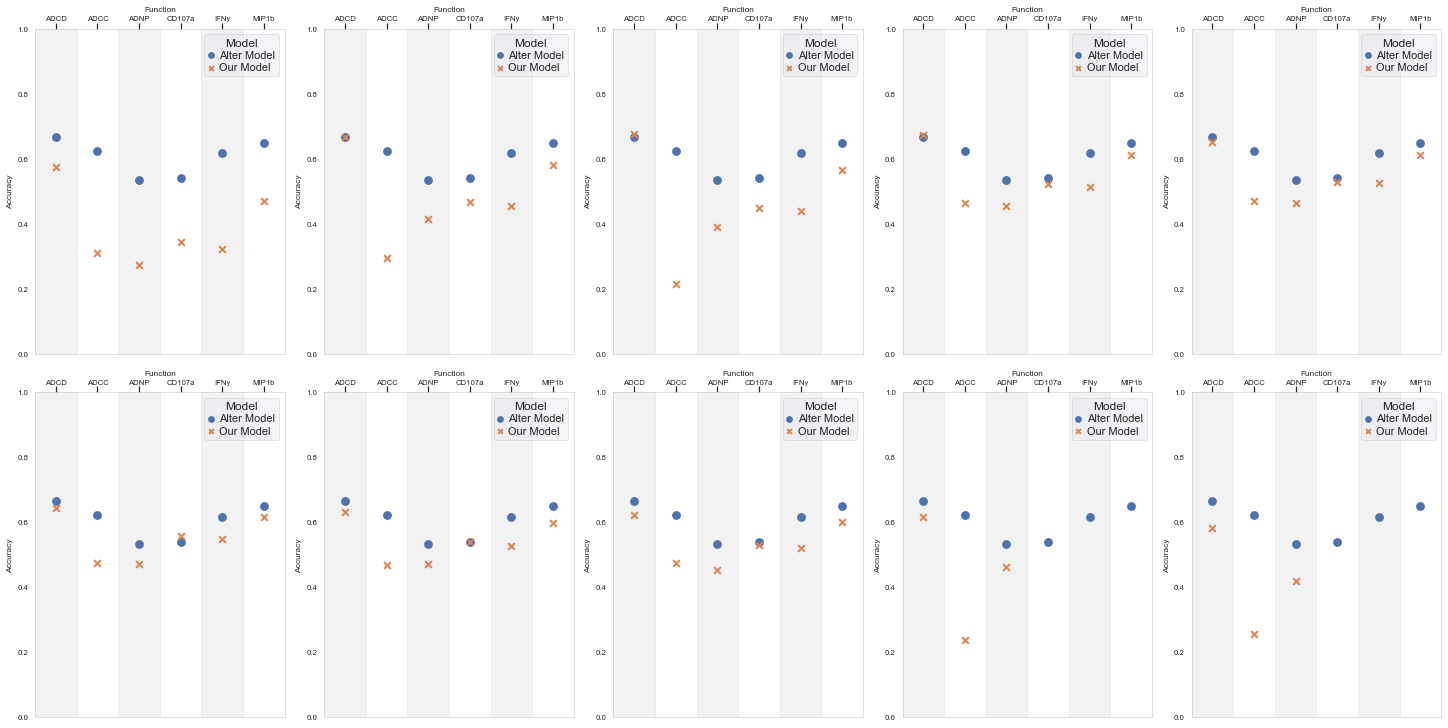

In [10]:
ax, f = getSetup((20, 10), (2, 5))
sns.set()
for i in range(10):
    # Function Plot
    a = sns.pointplot(
    y="Accuracy",
    x="Function",
    hue="Model",
    markers=["o", "x"],
    join=False,
    data=function_dfs[i],
    ax=ax[i],
    )
    # Formatting
    shades = [-0.5, 1.5, 3.5]
    for i in shades:
        a.axvspan(i, i + 1, alpha=0.1, color="grey")
    a.set_xlim(-0.5, 5.5)
    a.set_ylim(0, 1)
    a.grid(False)
    a.xaxis.tick_top()
    a.xaxis.set_label_position("top")
    a.tick_params(axis="x")
    a.set_ylabel("Accuracy")
    a.set_xlabel("Function")

In [7]:
from syserol.dataImport import getAxes, importIGG, importGlycan, importLuminex

LR Coefficient: [0.         3.52059078 0.02358213 9.44857493 5.02014728 6.8063752 ]
LR Coefficient: [ 10.36490932  67.00571393   5.86613569  18.94892712 -13.78592364
  21.65404678]
LR Coefficient: [  9.84511644 108.8583995  -43.36973008  84.15127935   8.9055712
  -0.        ]
LR Coefficient: [ 5.04961576 34.716904   -0.         31.45462086 -0.         -0.        ]
LR Coefficient: [ 8.15951732 45.18060231 -4.66551538 43.27660549 -3.02158723 -6.46181615]
LR Coefficient: [ 26.08730422 177.30967168  -4.60105664 138.38081078   6.8952348
  -5.55945083]
LR Coefficient: [0.         3.52059078 0.02358213 9.44857493 5.02014728 6.8063752 ]
LR Coefficient: [ 10.36490932  67.00571393   5.86613569  18.94892712 -13.78592364
  21.65404678]
LR Coefficient: [  9.84511644 108.8583995  -43.36973008  84.15127935   8.9055712
  -0.        ]
LR Coefficient: [ 5.04961576 34.716904   -0.         31.45462086 -0.         -0.        ]
LR Coefficient: [ 8.15951732 45.18060231 -4.66551538 43.27660549 -3.02158723 -6.

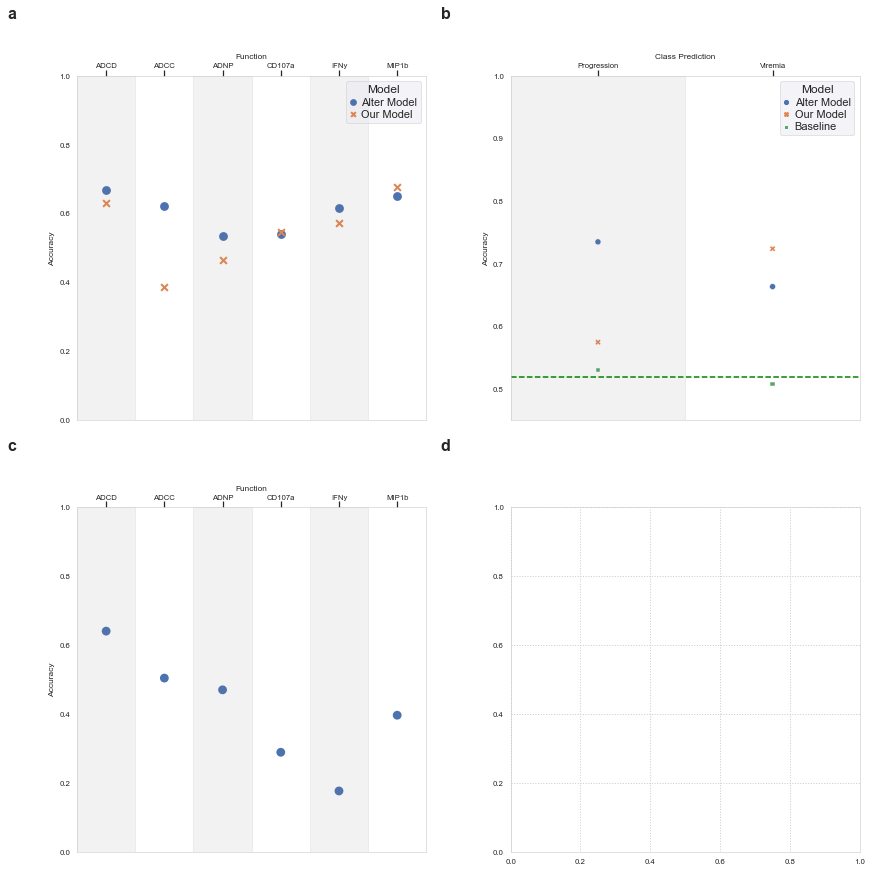

In [3]:
# Decompose Cube
tensorFac, _, _ = perform_CMTF()
# Gather Function Prediction Accuracies
accuracies = np.zeros(12)
for ii, func in enumerate(functions):
    _, _, acc, _ = function_elastic_net(func)  # Alter Function Predictions
    accuracies[ii] = acc  # store accuracies
for i, func in enumerate(functions):
    # our prediction accuracies
    _, _, accuracy = function_prediction(tensorFac, function=func, evaluation="Alter")
    accuracies[i + 6] = accuracy  # store

# Create DataFrame
model = ["Alter Model"] * 6 + ["Our Model"] * 6
function = functions + functions
data = {"Accuracy": accuracies, "Model": model, "Function": function}
functions_df = pd.DataFrame(data)  # Function Prediction DataFrame, Figure 2B

# Subjects left out of Alter
accuracies = np.zeros(6)
for i, func in enumerate(functions):
    _, _, accuracy = function_prediction(tensorFac, function=func, evaluation="notAlter")
    accuracies[i] = accuracy
# Create DataFrame
data = {"Accuracy": accuracies, "Function": functions}
subjects_out = pd.DataFrame(data) # DataFrame for Figure 2D

# Gather Class Prediction Accuracies
accuracyCvP, accuracyVvN = two_way_classifications()  # Alter accuracies
# Run our model
subjects_matrix = tensorFac[1][0]
cp_accuracy, nv_accuracy = class_predictions(subjects_matrix)  # Our accuracies

# Create DataFrame
baselineNV = 0.5083  # datasetEV3/Fc.array/class.nv/lambda.min/score_details.txt "No information rate"
baselineCP = 0.5304  # datasetEV3/Fc.array/class.cp/lambda.min/score_details.txt "No information rate"
avg = np.mean([baselineNV, baselineCP])
accuracies = np.array(
    [accuracyCvP, cp_accuracy, baselineCP, accuracyVvN, nv_accuracy, baselineNV]
)
category = ["Progression"] * 3 + ["Viremia"] * 3
model = ["Alter Model", "Our Model", "Baseline"] * 2
data = {"Accuracies": accuracies, "Class": category, "Model": model}
classes = pd.DataFrame(data)  # Class Predictions DataFrame, Figure 2C

# PLOT DataFrames
ax, f = getSetup((12, 12), (2, 2))
sns.set()
# Function Plot
a = sns.pointplot(
    y="Accuracy",
    x="Function",
    hue="Model",
    markers=["o", "x"],
    join=False,
    data=functions_df,
    ax=ax[0],
)
# Formatting
shades = [-0.5, 1.5, 3.5]
for i in shades:
    a.axvspan(i, i + 1, alpha=0.1, color="grey")
a.set_xlim(-0.5, 5.5)
a.set_ylim(0, 1)
a.grid(False)
a.xaxis.tick_top()
a.xaxis.set_label_position("top")
a.tick_params(axis="x")
a.set_ylabel("Accuracy")
a.set_xlabel("Function")

# Class Plot
b = sns.scatterplot(
    y="Accuracies", x="Class", style="Model", hue="Model", data=classes, ax=ax[1]
)
# Formatting
b.plot([-0.5, 5.5], [avg, avg], "--", color="green")
b.axvspan(-0.5, 0.5, alpha=0.1, color="grey")
b.set_xlim(-0.5, 1.5)
b.set_ylim(0.45, 1)
b.grid(False)
b.xaxis.tick_top()
b.xaxis.set_label_position("top")
b.set_ylabel("Accuracy")
b.set_xlabel("Class Prediction")
b.tick_params(axis="x")

# Function Predictions for Values left out of Alter Plot
c = sns.pointplot(
    x="Function", y="Accuracy", join=False, data=subjects_out, ax=ax[2]
)

# Formatting
shades = [-0.5, 1.5, 3.5]
for i in shades:
    c.axvspan(i, i + 1, alpha=0.1, color="grey")
c.set_xlim(-0.5, 5.5)
c.set_ylim(0, 1)
c.grid(False)
c.xaxis.tick_top()
c.xaxis.set_label_position("top")
c.tick_params(axis="x")
c.set_ylabel("Accuracy")
c.set_xlabel("Function")

subplotLabel(ax)

In [38]:
pd.set_option("display.min_rows", 100)
pd.set_option("display.max_rows", 100)

In [86]:
from scipy.stats import pearsonr
test = pd.read_csv("syserol/data/data-luminex.csv")
cols = [col for col in test.columns if "FcgRIIa" in col]

In [117]:
df = pd.DataFrame()
for i in range(24):
    test_col = [val for val in cols if val[-len(dict_2a["FcgRIIIa"][i]):] == dict_2a["FcgRIIIa"][i]]
    df = pd.concat((df, test[test_col]), axis=1)
df

FcgRIIIa.93TH975.gp120  FcgRIIIa.Chiang.Mai.gp120  \
0                   11006.0                    68402.3   
1                   11144.0                    57357.3   
2                   11843.5                    22025.8   
3                    1778.0                     5652.3   
4                    1979.0                     6542.3   
..                      ...                        ...   
176                  2372.0                    19862.8   
177                  5486.5                    61418.3   
178                  6889.0                    34646.3   
179                  7453.0                    31862.3   
180                 13023.5                    48762.8   

     FcgRIIIa.F158.gp120.BAL  FcgRIIIa.V158.gp120.BAL  FcgRIIIa.gp120.BAL  \
0                   100025.6                  65253.8            142710.5   
1                    30676.6                  13969.8            128386.5   
2                    16158.6                  10247.3            111220.5   
3                     8022.6                   4453.8             53534.5   
4                     1417.1                   1393.8             74704.0   
..                       ...                      ...                 ...   
176                  56724.6                  30897.8            127926.5   
177                  81087.6                  49687.8            128305.5   
178                  85098.6                  55635.8            136152.0   
179                  22414.6                  27159.8            117295.5   
180                    412.6                    432.3             15589.5   

     FcgRIIIa.F158.gp120.Du151  FcgRIIIa.V158.gp120.Du151  \
0                      81991.1                    54119.4   
1                      42974.1                    18704.4   
2                      77820.1                    38895.9   
3                        166.1                      189.9   
4                         89.6                      124.4   
..                         ...                        ...   
176                    48945.1                    23614.9   
177                    57696.1                    28685.9   
178                    46540.6                    18293.4   
179                    32069.6                    27899.9   
180                    21688.1                    16128.4   

     FcgRIIIa.gp120.Du151  FcgRIIIa.F158.gp120.Du156.12  \
0                138889.0                       20498.6   
1                108481.0                       52587.1   
2                121585.5                       76242.6   
3                  1436.0                        1068.6   
4                  1890.0                         296.6   
..                    ...                           ...   
176               74564.5                        2775.6   
177               91615.0                       56347.6   
178               98840.0                       76926.6   
179              108113.0                       22139.6   
180              100094.0                       48826.6   

     FcgRIIIa.V158.gp120.Du156.12  ...  FcgRIIIa.HIV1.Vif  \
0                         13068.0  ...             4654.0   
1                         12607.5  ...             4602.5   
2                         50132.0  ...              396.0   
3                           479.0  ...             1594.0   
4                            93.5  ...             2546.5   
..                            ...  ...                ...   
176                        2099.0  ...             4448.0   
177                       32903.5  ...             2124.0   
178                       41712.0  ...              732.5   
179                       21280.5  ...             5673.0   
180                       36493.0  ...             1418.0   

     FcgRIIIa.F158.p24.HXBc2  FcgRIIIa.V158.p24.HXBc2  FcgRIIIa.p24.HXBc2  \
0                   131137.4                  80613.9             80990.0   
1                    67553.4                  35443.9 

0.715285345497917 0.2812339849010308 0.5801977530292272


<AxesSubplot:xlabel='FcgRIIIa.Chiang.Mai.gp120', ylabel='FcgRIIIa.F158.gp120.BAL'>

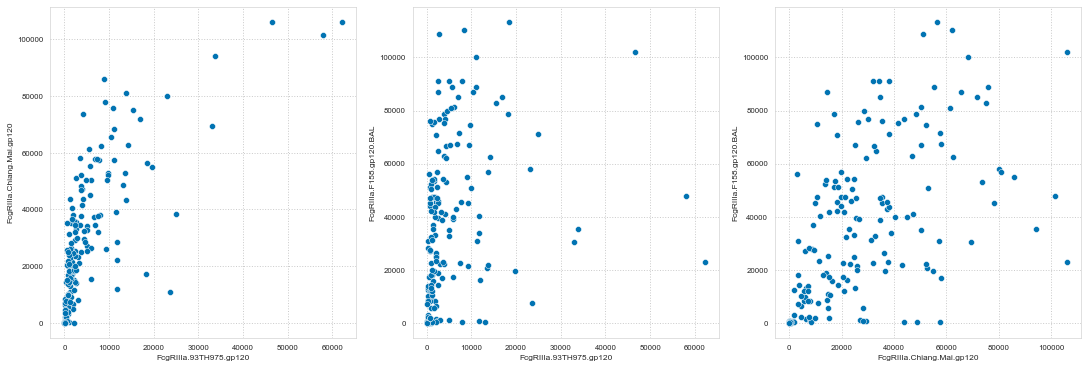

In [119]:
test_col = [val for val in cols if val[-len(dict_2a["FcgRIIIa"][3]):] == dict_2a["FcgRIIIa"][3]]
df.append(test[test_col])
print(pearsonr(df[df.columns[0]], df[df.columns[1]])[0], pearsonr(df[df.columns[0]], df[df.columns[2]])[0],pearsonr(df[df.columns[1]], df[df.columns[2]])[0])
ax, f = getSetup((15, 5), (1, 3))
sns.scatterplot(data=df, x=df.columns[0], y=df.columns[1], ax=ax[0])
sns.scatterplot(data=df, x=df.columns[0], y=df.columns[2], ax=ax[1])
sns.scatterplot(data=df, x=df.columns[1], y=df.columns[2], ax=ax[2])

In [77]:
test = pd.read_csv("syserol/data/data-luminex.csv")
cols = [col for col in test.columns if "FcgRIIa" in col]
test_col = [val for val in cols if val[-len(dict_2a["FcgRIIa"][16]):] == dict_2a["FcgRIIa"][16]]
df = test[test_col]
pearsonr(df["FcgRIIa.H131.IIIb.pr55.Gag"], df["FcgRIIa.R131.IIIb.pr55.Gag"])
#df["Index"] = df.index
#pd.melt(df, id_vars=["Index"])

(0.07513031056220981, 0.3148036193262933)

In [20]:
def fcg_df(receptor, geno1, geno2):
    test = pd.read_csv("syserol/data/data-luminex.csv")
    geno1 = receptor + "." + geno1
    geno2 = receptor + "." + geno2
    cols = [col for col in test.columns if receptor in col]
    dict = {geno1 : [],geno2 : [], receptor: []}
    for col in cols:
        if col[:len(geno1)] == geno1:
            dict[geno1].append(col[len(geno1) + 1:])
        elif col[:len(geno2)] == geno2:
            dict[geno2].append(col[len(geno2) + 1:])
        elif col[:len(receptor)] == receptor:
            dict[receptor].append(col[len(receptor) + 1:])
    all_antis = []
    for i in range(len(dict[receptor])):
        test_col = [val for val in cols if val[-len(dict[receptor][i]):] == dict[receptor][i]]
        anti = test[test_col]
        if test[test_col].shape[1] == 3:
            anti.columns = [geno1, geno2, receptor]
            all_antis.append(anti)
    df = pd.concat(all_antis)
    return df

(-4000.0, 166793.4)

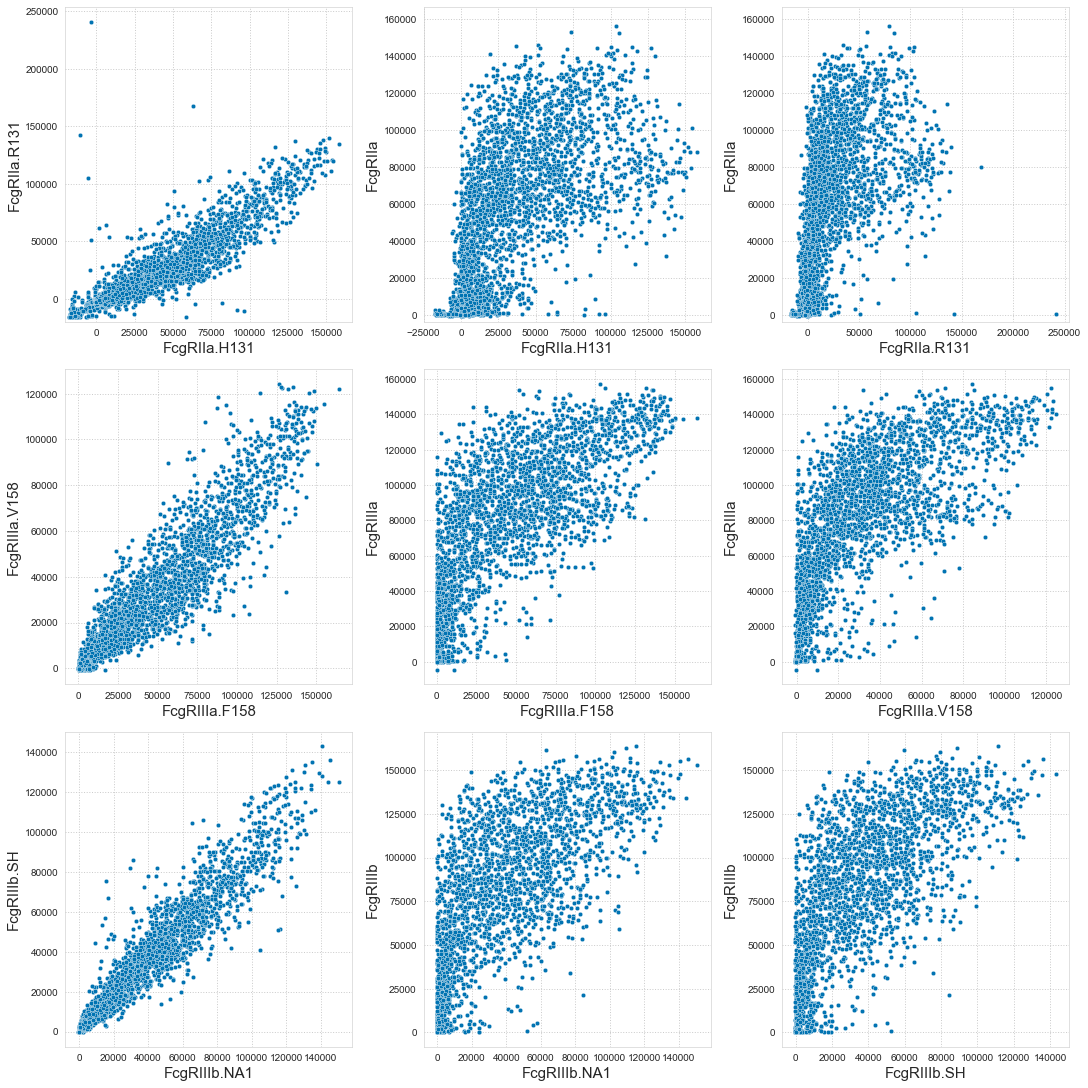

In [44]:
df_2a = fcg_df("FcgRIIa", "H131", "R131")
df_3a = fcg_df("FcgRIIIa", "F158", "V158")
df_3b = fcg_df("FcgRIIIb", "NA1", "SH")
#df["Index"] = df.index
#pd.melt(df, id_vars=["Index"])

ax, f = getSetup((15, 15), (3, 3))
a = sns.scatterplot(data=df_2a, x=df_2a.columns[0], y=df_2a.columns[1], s=20, ax=ax[0])
b = sns.scatterplot(data=df_2a, x=df_2a.columns[0], y=df_2a.columns[2], s=20, ax=ax[1])
c = sns.scatterplot(data=df_2a, x=df_2a.columns[1], y=df_2a.columns[2], s=20, ax=ax[2])
d = sns.scatterplot(data=df_3a, x=df_3a.columns[0], y=df_3a.columns[1], s=20, ax=ax[3])
e = sns.scatterplot(data=df_3a, x=df_3a.columns[0], y=df_3a.columns[2], s=20, ax=ax[4])
f = sns.scatterplot(data=df_3a, x=df_3a.columns[1], y=df_3a.columns[2], s=20, ax=ax[5])
g = sns.scatterplot(data=df_3b, x=df_3b.columns[0], y=df_3b.columns[1], s=20, ax=ax[6])
h = sns.scatterplot(data=df_3b, x=df_3b.columns[0], y=df_3b.columns[2], s=20, ax=ax[7])
i = sns.scatterplot(data=df_3b, x=df_3b.columns[1], y=df_3b.columns[2], s=20, ax=ax[8])
axes = [a, b, c, d, e, f, g, h, i]
for axis in axes:
    xlab = axis.get_xlabel()
    ylab = axis.get_ylabel()
    axis.set_xlabel(xlab, fontsize=15)
    axis.set_ylabel(ylab, fontsize=15)
    axis.tick_params(labelsize=10)
a.set_xlim(-20000)
a.set_ylim(-20000)
b.set_xlim(-25000)
b.set_ylim(-4000)
c.set_xlim(-25000)
c.set_ylim(-4000)

In [3]:
test = pd.read_csv("syserol/data/data-luminex.csv")
cols = [col for col in test.columns if "FcgRIIIa" in col]
dict_2a = {"FcgRIIIa.F158" : [], "FcgRIIIa.V158" : [], "FcgRIIIa": []}
for col in cols:
    if col[:13] == "FcgRIIIa.F158":
        dict_2a["FcgRIIIa.F158"].append(col[14:])
    elif col[:13] == "FcgRIIIa.V158":
        dict_2a["FcgRIIIa.V158"].append(col[14:])
    else:
        dict_2a["FcgRIIIa"].append(col[9:])
dict_2a

{'FcgRIIIa.F158': ['6H.HIV1.p66',
  'gp120.96ZM651',
  'gp120.BAL',
  'gp120.BAL.Kif',
  'gp120.CM',
  'gp120.CM244',
  'gp120.CN54',
  'gp120.Du151',
  'gp120.Du156.12',
  'gp120.IIIb',
  'gp120.JRCSF',
  'gp120.MN',
  'gp120.PVO',
  'gp120.RSC3',
  'gp120.SF162',
  'gp120.TRO',
  'gp120.YU2',
  'gp120.ZM109F',
  'gp140.BR29',
  'gp140.Du151',
  'gp140.UG21',
  'gp41.HXBc2',
  'HIV1.p7',
  'IIIb.pr55.Gag',
  'p24.HXBc2',
  'p24.IIIb',
  'p51.HIV1.RT',
  'gp120.RSC3.delta3711',
  'SOSIP'],
 'FcgRIIIa.V158': ['6H.HIV1.p66',
  'gp120.96ZM651',
  'gp120.BAL',
  'gp120.BAL.Kif',
  'gp120.CM',
  'gp120.CM244',
  'gp120.CN54',
  'gp120.Du151',
  'gp120.Du156.12',
  'gp120.IIIb',
  'gp120.JRCSF',
  'gp120.MN',
  'gp120.PVO',
  'gp120.RSC3',
  'gp120.SF162',
  'gp120.TRO',
  'gp120.YU2',
  'gp120.ZM109F',
  'gp140.BR29',
  'gp140.Du151',
  'gp140.UG21',
  'gp41.HXBc2',
  'HIV1.p7',
  'IIIb.pr55.Gag',
  'p24.HXBc2',
  'p24.IIIb',
  'p51.HIV1.RT',
  'gp120.RSC3.delta3711',
  'SOSIP'],
 'FcgRIIIa